In [0]:
import boto3
import pandas as pd
import numpy as np

In [0]:
dbutils.library.installPyPI("pandas", "1.4.2")
dbutils.library.restartPython()

dbutils.library APIs are deprecated and will be removed in a future DBR release. You can use %pip commands to install notebook scoped python libraries.
PyPI package pandas has been installed already. The previously installed package is `pandas==1.4.2`. To resolve this issue, detach and re-attach the notebook to create a new environment or rename the package.

In [0]:
import pandas as pd
df = pd.read_csv("/dbfs/FileStore/shared_uploads/yl4575@columbia.edu/results-1.csv")

In [0]:
import numpy as np
df = df.replace(r'\N', np.NaN)
df.head()

Out[2]:

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [0]:
df.shape

Out[3]: (25399, 18)

In [0]:
df.dropna(how='all').shape

Out[4]: (25399, 18)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['driverId','constructorId','grid','points','laps','statusId']], df[["positionOrder"]].values.ravel(), random_state=42)

In [0]:
X_train.head()

Out[6]:

,driverId,constructorId,grid,points,laps,statusId
7948,146,49,0,0.0,0,97
2640,30,6,4,0.0,24,22
20361,16,10,10,0.0,9,5
18337,522,113,5,0.0,85,121
7912,117,1,2,6.0,58,1


In [0]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [0]:
mlflow.end_run()

In [0]:
with mlflow.start_run(run_name="Basic RF Experiment") as run:
 # Create model, train it, and create predictions
 rf = RandomForestRegressor()
 rf.fit(X_train, y_train)
 predictions = rf.predict(X_test)

 # Log model
 mlflow.sklearn.log_model(rf, "random-forest-model")
 # Create metrics
 mse = mean_squared_error(y_test, predictions)
 print("  mse: {}".format(mse))

 # Log metrics
 mlflow.log_metric("mse", mse)

 runID = run.info.run_uuid
 experimentID = run.info.experiment_id
    
 print("Inside MLflow Run with run_id {} and experiment_id {}".format(runID, experimentID))

mse: 5.907952097015472
Inside MLflow Run with run_id 53feb7af7adb4d8d93ac96c604fcf4e3 and experiment_id 1145396779780739

In [0]:

def log_rf(experimentID, run_name, params, X_train, X_test, y_train, y_test):
 import os
 import matplotlib.pyplot as plt
 import mlflow.sklearn
 import seaborn as sns
 from sklearn.ensemble import RandomForestRegressor
 from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 import tempfile

 with mlflow.start_run(experiment_id=experimentID, run_name=run_name) as run:
   # Create model, train it, and create predictions
   rf = RandomForestRegressor(**params)
   rf.fit(X_train, y_train)
   predictions = rf.predict(X_test)

   # Log model
   mlflow.sklearn.log_model(rf, "random-forest-model")

   # Log params
   [mlflow.log_param(param, value) for param, value in params.items()]

   # Create metrics
   mse = mean_squared_error(y_test, predictions)
   mae = mean_absolute_error(y_test, predictions)
   r2 = r2_score(y_test, predictions)
   print("  mse: {}".format(mse))
   print("  mae: {}".format(mae))
   print("  R2: {}".format(r2))

   # Log metrics
   mlflow.log_metric("mse", mse)
   mlflow.log_metric("mae", mae) 
   mlflow.log_metric("r2", r2) 

   # Create feature importance
   importance = pd.DataFrame(list(zip(df.columns, rf.feature_importances_)),
                               columns=["Feature", "Importance"]
                             ).sort_values("Importance", ascending=False)
  
   # Log importances using a temporary file
   temp = tempfile.NamedTemporaryFile(prefix="feature-importance-", suffix=".csv")
   temp_name = temp.name
   try:
     importance.to_csv(temp_name, index=False)
     mlflow.log_artifact(temp_name, "feature-importance.csv")
   finally:
     temp.close() # Delete the temp file
  
   # Create plot
   fig, ax = plt.subplots()

   sns.residplot(predictions, y_test, lowess=True)
   plt.xlabel("Predicted values for Rank ($)")
   plt.ylabel("Residual")
   plt.title("Residual Plot")

   # Log residuals using a temporary file
   temp = tempfile.NamedTemporaryFile(prefix="residuals-", suffix=".png")
   temp_name = temp.name
   try:
     fig.savefig(temp_name)
     mlflow.log_artifact(temp_name, "residuals.png")
   finally:
     temp.close() # Delete the temp file

   display(fig)
   return run.info.run_uuid

mse: 7.5192163415115525
 mae: 1.9053940304150874
 R2: 0.8751844337913859
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

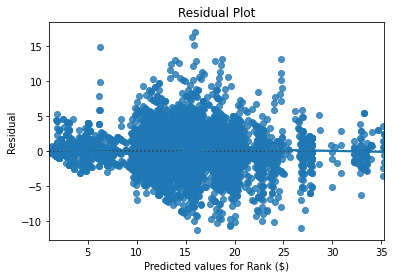

Out[11]: '8cc07904908b4e6db368075e95fbae78'

In [0]:
params = {
 "n_estimators": 100,
 "max_depth": 7,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 2
}

log_rf(experimentID, "Second Run", params, X_train, X_test, y_train, y_test)

mse: 7.520403418759923
 mae: 1.905636986799458
 R2: 0.8751647288497857
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

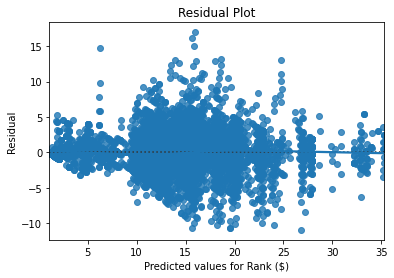

Out[12]: '382255329f434cb4ba5a9d23d3a178f5'

In [0]:
params = {
 "n_estimators": 100,
 "max_depth": 7,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 3
}

log_rf(experimentID, "Third Run", params, X_train, X_test, y_train, y_test)

mse: 7.517861990780133
 mae: 1.906015531622513
 R2: 0.8752069153966104
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

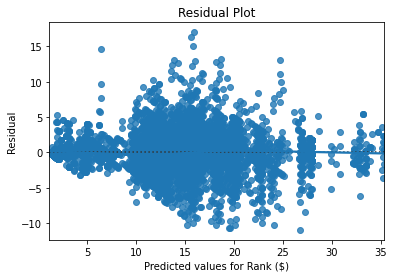

Out[13]: 'bbc817d4f5fc495fbe3f89840b3bff8a'

In [0]:
params = {
 "n_estimators": 110,
 "max_depth": 7,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 3
}

log_rf(experimentID, "Fourth Run", params, X_train, X_test, y_train, y_test)

mse: 6.077159196878846
 mae: 1.6658046428333084
 R2: 0.8991219255242446
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

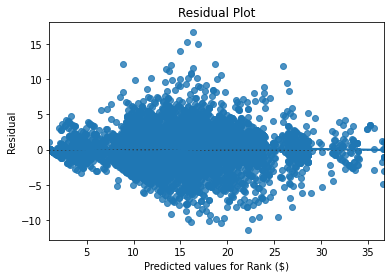

Out[14]: '07c94399c374416599be00c0abf449ce'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth": 10,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 3
}

log_rf(experimentID, "Fifth Run", params, X_train, X_test, y_train, y_test)

mse: 6.0680898407012265
 mae: 1.6646533351389858
 R2: 0.899272472705632
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

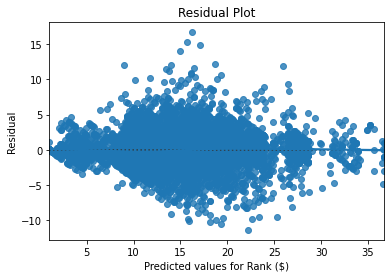

Out[15]: '5c56754f90bd452180a53ba884bf0484'

In [0]:
params = {
 "n_estimators": 130,
 "max_depth": 10,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 4
}

log_rf(experimentID, "Sixth Run", params, X_train, X_test, y_train, y_test)

mse: 9.51490805018871
 mae: 2.2223725155888157
 R2: 0.8420568604801622
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

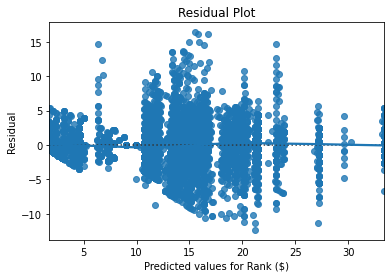

Out[16]: '317aebc1738a4398b14ff324aeeb5457'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth":5,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 3
}

log_rf(experimentID, "Seventh Run", params, X_train, X_test, y_train, y_test)

mse: 12.411506248850973
 mae: 2.6161791006335586
 R2: 0.7939746498049732
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

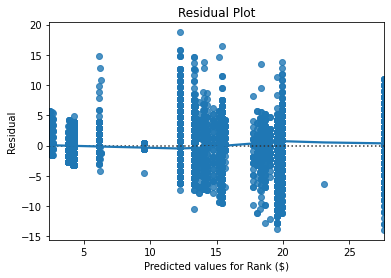

Out[17]: '2ef56ba26a9c4ae78e7aa45b453fbff8'

In [0]:
params = {
 "n_estimators": 110,
 "max_depth":3,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 2
}

log_rf(experimentID, "Eighth Run", params, X_train, X_test, y_train, y_test)

mse: 7.510218731999695
 mae: 1.9045726686915492
 R2: 0.8753337900108029
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

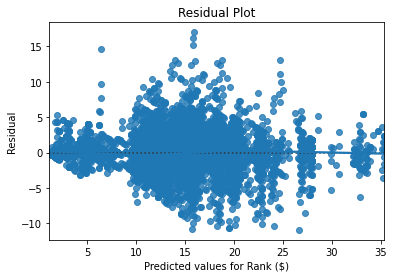

Out[18]: '7dc82e8930134fd894d45b21024317dc'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth":7,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 2
}

log_rf(experimentID, "Nineth Run", params, X_train, X_test, y_train, y_test)

mse: 7.511414440987322
 mae: 1.9048280835861036
 R2: 0.8753139417862629
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

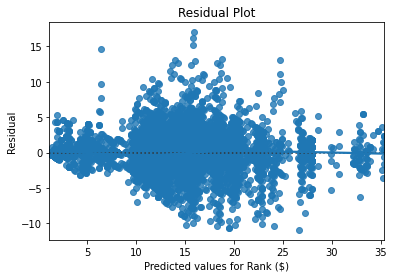

Out[19]: '122340b944d84e4aa94d63ab22b54b56'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth":7,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 3
}

log_rf(experimentID, "Tenth Run", params, X_train, X_test, y_train, y_test)

mse: 5.87681060272854
 mae: 1.6299387861592016
 R2: 0.9024476209268247
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

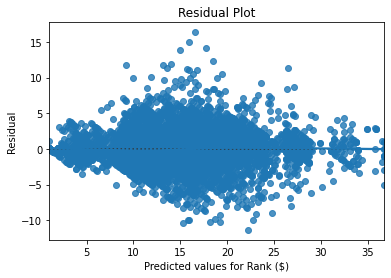

Out[20]: '6e223fde5b2b41f2af673e1f97cd65ed'

In [0]:
params = {
 "n_estimators": 150,
 "max_depth":11,
 "random_state": 42,
 'min_samples_leaf': 1,
'min_samples_split': 5
}

log_rf(experimentID, "Eleventh Run", params, X_train, X_test, y_train, y_test)

mse: 5.72539508856068
 mae: 1.5957667595150917
 R2: 0.9049610494910879
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

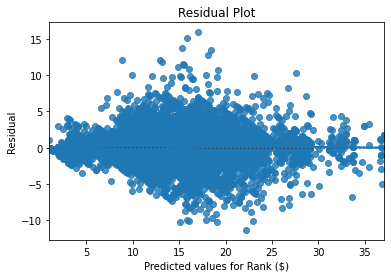

Out[21]: '74975f3e1e9a4e47a84f1873fd221dc1'

In [0]:
params = {
 "n_estimators": 150,
 "max_depth":13,
 "random_state": 42,
 'min_samples_leaf': 2,
'min_samples_split': 5
}

log_rf(experimentID, "12th Run", params, X_train, X_test, y_train, y_test)

In [0]:
### The above 12th model was evaluated by MSE, MAE and R-square. As is shown in the MLFlow running results, this model performed the best because its result shows the lowest MSE and MAE and the highest R-square. These metrics mean the model performs the best comparing other models.

mse: 8.459362358650408
 mae: 2.0620583971320507
 R2: 0.8595784381505729
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

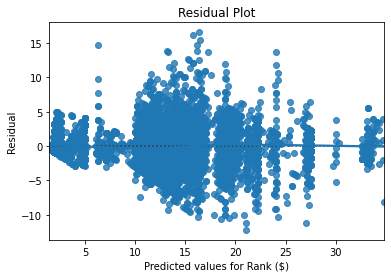

Out[23]: 'c7955ca45c814b82be948d59f0eacc79'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth":6,
 "random_state": 42,
 'min_samples_leaf': 2,
'min_samples_split': 3
}

log_rf(experimentID, "13th Run", params, X_train, X_test, y_train, y_test)

mse: 8.459362358650408
 mae: 2.0620583971320507
 R2: 0.8595784381505729
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

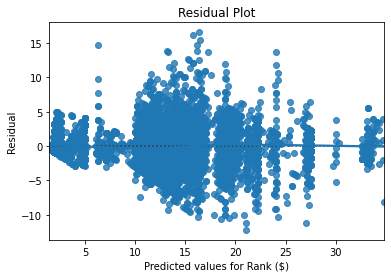

Out[24]: '2b6548e828d4472497cfa2900c626b1d'

In [0]:
params = {
 "n_estimators": 120,
 "max_depth":6,
 "random_state": 42,
 'min_samples_leaf': 2,
'min_samples_split': 3
}

log_rf(experimentID, "13th Run", params, X_train, X_test, y_train, y_test)